In [1]:
# Load .env and display model environment variables used by agents
import os
from dotenv import load_dotenv
load_dotenv()
print({k: os.getenv(k) for k in [
    "MODEL_NAME",
    "TEACHER_MODEL",
    "GRADING_MODEL",
    "COORDINATOR_MODEL",
    "STUDENT_MODEL",
    "CRITIQUE_EVAL_MODEL",
]})

{'MODEL_NAME': 'gpt-4o-mini', 'TEACHER_MODEL': 'gpt-4o-mini', 'GRADING_MODEL': 'gpt-4o-mini', 'COORDINATOR_MODEL': 'gpt-4o-mini', 'STUDENT_MODEL': 'gpt-4o-mini', 'CRITIQUE_EVAL_MODEL': 'gpt-4o-mini'}


In [ ]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

sys.path.insert(0, str(Path.cwd().parent))  # add repo root

from src.agents.common import PERSONAS, StopConfig
from src.agents.coordinator_agent import coordinator_node
from src.agents.teacher_agent import teacher_node
from src.agents.student_agent import students_node
from src.agents.critique_eval_agent import reward_node
from src.agents.stopping_agent import stopper_node

# Reload grading and judge modules to pick up code changes without restarting kernel
import src.agents.grading_agent as grading_agent_mod
importlib.reload(grading_agent_mod)
from src.agents.grading_agent import grading_node

import src.agents.judge_agent as judge_agent_mod
importlib.reload(judge_agent_mod)
from src.agents.judge_agent import judge_node

THRESHOLD = 0.7
MAX_ITERS = 5
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [25]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)


def trulens_relevance(question: str, explanation: str):
    """Return a simple relevance score via TruLens provider, or None if unavailable."""
    if tru_provider is None:
        return None
    try:
        res = tru_provider.relevance_with_cot_reasons(question, explanation)
        # Try to normalize to float if structure varies across versions
        if isinstance(res, dict):
            for k in ("score", "value", "score_value"):
                if k in res and res[k] is not None:
                    return float(res[k])
            return None
        # object-like
        score = getattr(res, "score", None) or getattr(res, "value", None)
        return float(score) if score is not None else None
    except Exception:
        return None

In [ ]:
# build LangGraph graph for multi-agent refinement + TruLens session
from typing import Dict, List, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END

class State(TypedDict, total=False):
    question: str
    topics: List[str]
    explanation: str
    student_responses: Dict[str, str]
    reward_scores: Dict[str, int]
    history: List[Dict]
    iteration: int
    threshold: float
    max_iters: int
    decision: str
    reason: str
    quiz: List[Dict[str, Any]]
    quiz_answers: Dict[str, Dict[str, str]]
    quiz_results: Dict[str, Any]
    judge_scores: Dict[str, int]
    judge_rationales: Dict[str, str]
    judge_overall: float

graph = StateGraph(State)

graph.add_node("coordinator", coordinator_node)

graph.add_node("teacher", teacher_node)

graph.add_node("students", students_node)

graph.add_node("reward", reward_node)

graph.add_node("stopper", stopper_node)

graph.add_node("judge", judge_node)

graph.add_node("grading", grading_node)

# edges
graph.add_edge("coordinator", "teacher")
graph.add_edge("teacher", "students")
graph.add_edge("students", "reward")
graph.add_edge("reward", "stopper")
graph.add_edge("judge", "grading")
graph.add_edge("grading", END)

# routing from stopper: STOP -> judge -> grading -> END; CONTINUE -> coordinator

def route_from_stop(state: State) -> str:
    return "judge" if state.get("decision") == "STOP" else "coordinator"

graph.add_conditional_edges("stopper", route_from_stop, {"judge": "judge", "coordinator": "coordinator"})

graph.set_entry_point("coordinator")
compiled_graph = graph.compile()

# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)
    tru_recorder = TruGraph(compiled_graph, app_name="Educational Refinement Agent", app_version="mvp")
except Exception as e:
    tru_recorder = None
    print("TruGraph init failed:", e)

Singleton instance TruSession already exists for name = None.


🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream


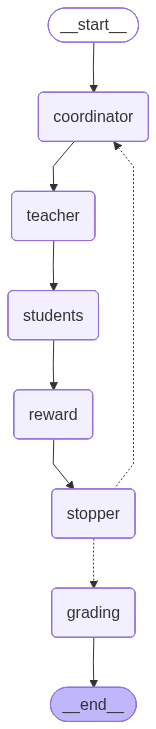

In [13]:

from IPython.display import Image

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [ ]:
# demo run on an example question using TruGraph context manager (logs to TruLens)
# QUESTION = "How does gradient descent work?"
# initial_state = {
#     "question": QUESTION,
#     "threshold": THRESHOLD,
#     "max_iters": MAX_ITERS,
#     "history": [],
# }

# # Preferred pattern: use TruGraph as a context manager to record the run
# if 'tru_recorder' in globals() and tru_recorder is not None:
#     with tru_recorder as recording:
#         state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})
# else:
#     state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})

# results = {
#     "question": state.get("question", QUESTION),
#     "topics": state.get("topics", []),
#     "iterations": state.get("iteration", 0),
#     "final_scores": state.get("reward_scores", {}),
#     "final_explanation": state.get("explanation", ""),
#     "history": state.get("history", []),
# }

# print("Question:", results["question"]) 
# print("Topics:", ", ".join(results["topics"]))
# print("Iterations:", results["iterations"]) 
# print("Final scores:", results["final_scores"]) 
# print("\nFinal explanation (truncated to 800 chars):\n")
# print(results["final_explanation"][:800])

RuntimeError: generator raised StopIteration

In [ ]:
import json, random
from pathlib import Path

rng = random.Random(42)
problems_path = Path("data") / "sample_problems.json"
if not problems_path.exists():
    problems_path = Path.cwd().parent / "data" / "sample_problems.json"

QUESTION = "How does gradient descent work?"
PROBLEM_ID = None
PROBLEM_METADATA = {}
try:
    data = json.loads(problems_path.read_text(encoding="utf-8"))
    probs = data.get("problems", [])
    if isinstance(probs, list) and len(probs) > 0:
        choice = rng.choice(probs)
        PROBLEM_ID = choice.get("id")
        QUESTION = choice.get("question", QUESTION)
        PROBLEM_METADATA = choice
except Exception as e:
    print("Problem load failed:", e, "| path tried:", problems_path)

initial_state = {
    "question": QUESTION,
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": [],
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})

results = {
    "question": state.get("question", QUESTION),
    "topics": state.get("topics", []),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
    "problem_id": PROBLEM_ID,
    "quiz": state.get("quiz", []),
    "quiz_answers": state.get("quiz_answers", {}),
    "quiz_results": state.get("quiz_results", {}),
    "judge_scores": state.get("judge_scores", {}),
    "judge_rationales": state.get("judge_rationales", {}),
    "judge_overall": state.get("judge_overall", 0.0),
}

print("Problem:", PROBLEM_ID)
print("Question:", results["question"]) 
print("Topics:", ", ".join(results["topics"]))
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

# Print quiz and results if available
quiz = results.get("quiz", [])
quiz_results = results.get("quiz_results", {})
if quiz:
    print("\nQuiz (generated):")
    for i, q in enumerate(quiz, start=1):
        stem = q.get("stem", "").strip()
        options = q.get("options", [])
        correct = q.get("correct", "?")
        print(f"- Q{i} ({q.get('id','')}): {stem}")
        for opt in options:
            print(f"  {opt}")
        print(f"  Correct: {correct}")

if quiz_results:
    total = quiz_results.get("total_questions", 0)
    overall = quiz_results.get("overall_score", 0.0)
    scores_by_persona = quiz_results.get("scores_by_persona", {})
    correct_counts = quiz_results.get("correct_counts", {})
    print("\nQuiz Results:")
    print(f"- Total questions: {total}")
    print(f"- Overall score: {overall*100:.1f}%")
    print("- Scores by persona:")
    for p in sorted(scores_by_persona.keys()):
        sc = scores_by_persona[p]
        cc = correct_counts.get(p, 0)
        print(f"  {p}: {sc*100:.1f}% ({cc}/{total})")

# Print LLM judge summary if available
judge_scores = results.get("judge_scores", {})
if judge_scores:
    judge_overall = float(results.get("judge_overall", 0.0))
    print("\nLLM Judge:")
    for m in sorted(judge_scores.keys()):
        print(f"- {m}: {judge_scores[m]}")
    print(f"- overall: {judge_overall:.2f} (mean of metrics)")
    jr = results.get("judge_rationales", {})
    shown = 0
    for m in sorted(jr.keys()):
        if shown >= 2:
            break
        r = str(jr[m]).strip()
        if r:
            print(f"  rationale[{m}]: {r}")
            shown += 1

# Persist results to results/ with timestamped filename
_ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _slugify(s: str, limit: int = 40) -> str:
    s = (s or "").strip()
    slug = "".join(ch if ch.isalnum() else "_" for ch in s)
    return slug[:limit] if limit > 0 else slug

_id_part = PROBLEM_ID if PROBLEM_ID else _slugify(results["question"]) or "run"
outfile = BASE_OUT / f"run_{_ts}_{_id_part}.json"
record = {
    "timestamp": _ts,
    "problem_id": PROBLEM_ID,
    "question": results["question"],
    "final_explanation": results["final_explanation"],
    "topics": results["topics"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "quiz": results.get("quiz", []),
    "quiz_answers": results.get("quiz_answers", {}),
    "quiz_results": results.get("quiz_results", {}),
    "judge_scores": results.get("judge_scores", {}),
    "judge_rationales": results.get("judge_rationales", {}),
    "judge_overall": results.get("judge_overall", 0.0),
}
outfile.write_text(json.dumps(record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nSaved results to: {outfile}")

Problem: gauss_law_sphere
Question: Use Gauss’s law to find the electric field of a uniformly charged solid sphere (total charge Q, radius R) inside and outside.
Topics: implications of non-uniform charge distributions, examples with specific numerical calculations, visualization techniques for electric fields, comparison of electric fields for different charge distributions, applications of Gauss's law in real-world scenarios, derivation of electric field for hollow versus solid spheres, concept of electric field lines and their representation, relationship between electric field and potential energy, effects of dielectric materials on electric fields, advanced applications of Gauss's law in electrostatics
Iterations: 5
Final scores: {'advanced': 3, 'struggling': 3, 'visual': 3, 'practical': 3, 'theoretical': 3}

Final explanation (truncated to 800 chars):

Gauss's law states that the electric flux through a closed surface is proportional to the enclosed charge. For a uniformly charge

In [16]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://localhost:61361 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>